In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt
import numpy as np
import os

In [29]:
import cv2

PATHS = [os.getcwd() + "\\images\\without_mask", os.getcwd() + "\\images\\with_mask"]
X, y = [], []

for PATH in PATHS:
    label = PATH.split(os.path.sep)[-1]
    for img in os.listdir(PATH):
        img = load_img(os.path.join(PATH, img), target_size=(224, 224))
        img = img_to_array(img)
        img = preprocess_input(img)
        X.append(img)
        y.append(label)
#         break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


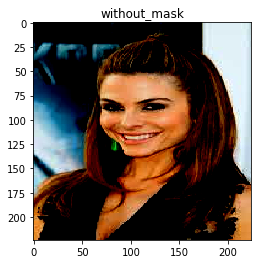

In [31]:
plt.imshow(X[122])
plt.title(y[122])
plt.show()

In [32]:
X = np.array(X, dtype="float32")
y = np.array(y)

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

lb = LabelBinarizer()
y = lb.fit_transform(y)
y = to_categorical(y)

trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, random_state=42)

aug = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")

In [38]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input

baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

In [39]:
from tensorflow.keras.models import Model

headModel = baseModel.output
headModel = keras.layers.AveragePooling2D(pool_size=(7,7))(headModel)
headModel = keras.layers.Flatten(name="flatten")(headModel)
headModel = keras.layers.Dense(128, activation="relu")(headModel)
headModel = keras.layers.Dropout(0.5)(headModel)
headModel = keras.layers.Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

In [40]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

H = model.fit(
    aug.flow(trainX, trainY, batch_size=32),
    steps_per_epoch=len(trainX) // 32,
    validation_data=(testX, testY),
    validation_steps=len(testX) // 32,
    epochs=20)

Epoch 1/20
33/33 [==============================] - 48s 1s/step - loss: 0.1217 - accuracy: 0.9492 - val_loss: 0.0165 - val_accuracy: 0.9963
Epoch 2/20
33/33 [==============================] - 47s 1s/step - loss: 0.0315 - accuracy: 0.9886 - val_loss: 0.0099 - val_accuracy: 1.0000
Epoch 3/20
33/33 [==============================] - 46s 1s/step - loss: 0.0243 - accuracy: 0.9904 - val_loss: 0.0185 - val_accuracy: 0.9926
Epoch 4/20
33/33 [==============================] - 47s 1s/step - loss: 0.0187 - accuracy: 0.9914 - val_loss: 0.0149 - val_accuracy: 0.9926
Epoch 5/20
33/33 [==============================] - 48s 1s/step - loss: 0.0131 - accuracy: 0.9942 - val_loss: 0.0133 - val_accuracy: 0.9926
Epoch 6/20
33/33 [==============================] - 45s 1s/step - loss: 0.0290 - accuracy: 0.9914 - val_loss: 0.0297 - val_accuracy: 0.9926
Epoch 7/20
33/33 [==============================] - 49s 1s/step - loss: 0.0205 - accuracy: 0.9933 - val_loss: 0.0114 - val_accuracy: 0.9963
Epoch 8/20
33/33 [==

In [41]:
model.save("models\MobileNetV2.h5")